In [1]:
import torch
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES #, NodeBool, NodeType, NodeParams, EdgeSubA, EdgeSubB, EdgeType
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint
from functools import partial
from IPython import display
import os

In [2]:
class CosineSchedule(nn.Module):
  def __init__(self, max_timestep : Tensor, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep
    self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

    # Cosine Variance Schedule Formula: https://arxiv.org/abs/2102.09672
    self.cumulative_precisions = torch.cos((torch.linspace(start = 0.0, end = 1.0, steps = self.max_timestep).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2
    self.cumulative_precisions = self.cumulative_precisions / self.cumulative_precisions[0]
    self.cumulative_precisions = self.cumulative_precisions.clamp(min = 1e-8, max = 1.0)

    self.cumulative_variances = 1 - self.cumulative_precisions
    self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])])
    self.precisions = 1 - self.variances
    self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
    self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
    self.sqrt_precisions = torch.sqrt(self.precisions)
    self.sqrt_variances = torch.sqrt(self.variances)
    self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])


In [3]:
class PowerSchedule(nn.Module):
  def __init__(self, max_timestep : Tensor, exponent : float, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep

    # Square Root Variance Schedule
    self.cumulative_precisions = 1.0 - torch.linspace(start = 0.0, end = 1.0, steps = self.max_timestep).to(self.device) ** exponent
    self.cumulative_precisions = self.cumulative_precisions.clamp(min = 1e-8, max = 1.0)

    self.cumulative_variances = 1 - self.cumulative_precisions
    self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])])
    self.precisions = 1 - self.variances
    self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
    self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
    self.sqrt_precisions = torch.sqrt(self.precisions)
    self.sqrt_variances = torch.sqrt(self.variances)
    self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])


In [4]:
class LinearSchedule(nn.Module):
  def __init__(self, max_timestep : Tensor, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep

    # Square Root Variance Schedule
    self.cumulative_precisions = 1.0 - torch.linspace(start = 0.0, end = 1.0, steps = self.max_timestep).to(self.device)
    self.cumulative_precisions = self.cumulative_precisions.clamp(min = 1e-8, max = 1.0)

    self.cumulative_variances = 1 - self.cumulative_precisions
    self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])])
    self.precisions = 1 - self.variances
    self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
    self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
    self.sqrt_precisions = torch.sqrt(self.precisions)
    self.sqrt_variances = torch.sqrt(self.variances)
    self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])

In [55]:

class NoiseScheduler(nn.Module):
  def __init__(self, max_timestep : int, device : torch.device):
    super().__init__()
    self.device = device

    # --- Variance Schedule --- #
    self.normal_schedule = CosineSchedule(max_timestep = max_timestep, device = self.device)
    self.gumbel_schedule = SqrtSchedule(max_timestep = max_timestep, device = self.device)

    # --- Probability Distributions --- #
    self.normal_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    self.gumbel_dist = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]))

  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    ''' Apply noise to graph '''
    noisy_nodes = torch.zeros(size = nodes.size(), device = self.device)
    noisy_edges = torch.zeros(size = edges.size(), device = self.device)
    true_node_noise = torch.zeros(size = nodes.size(), device = self.device)
    true_edge_noise = torch.zeros(size = edges.size(), device = self.device)

    # nodes = batch_size x num_nodes x NODE_FEATURE_DIMENSION ; edges = batch_size x num_nodes x num_nodes x EDGE_FEATURE_DIMENSION
    bernoulli_is_constructible = nodes[:,:,[0]] # batch_size x num_nodes x 1
    categorical_primitive_types = nodes[:,:,1:6] # batch_size x num_nodes x 5
    gaussian_primitive_parameters = nodes[:,:,6:] # batch_size x num_nodes x 14

    # subnode just means if the constraint applies to the start, center, or end of a primitive
    categorical_subnode_a_types = edges[:,:,:,0:4] # batch_size x num_nodes x 4
    categorical_subnode_b_types = edges[:,:,:,4:8] # batch_size x num_nodes x 4
    categorical_constraint_types = edges[:,:,:,8:] # batch_size x num_nodes x 9

    # IsConstructible noise
    b, n, _ = bernoulli_is_constructible.size()
    is_construct_noise = ( self.gumbel_dist.sample((b, n)) - self.gumbel_dist.sample((b, n)) ).to(self.device) # standard logistic noise; (b, n, 1)
    true_node_noise[...,0] = is_construct_noise.squeeze(-1)
    noisy_nodes[:,:,0] = self.apply_binary_noise(bernoulli_is_constructible, is_construct_noise, timestep)

    # Primitive Types noise
    prim_type_noise = self.gumbel_dist.sample(categorical_primitive_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 5)
    true_node_noise[...,1:6] = prim_type_noise
    noisy_nodes[:,:,1:6] = self.apply_discrete_noise(categorical_primitive_types, prim_type_noise, timestep) # noised_primitive_types

    # Primitive parameters noise
    parameter_noise = self.normal_dist.sample(gaussian_primitive_parameters.size()).to(self.device).squeeze(-1) # standard gaussian noise; (b, n, 14)
    true_node_noise[:,:,6:] = parameter_noise
    noisy_nodes[:,:,6:] = self.apply_gaussian_noise(gaussian_primitive_parameters, timestep, parameter_noise)

    # Subnode A noise
    suba_type_noise = self.gumbel_dist.sample(categorical_subnode_a_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 4)
    true_edge_noise[...,0:4] = suba_type_noise
    noisy_edges[:,:,:,0:4] = self.apply_discrete_noise(categorical_subnode_a_types, suba_type_noise, timestep) # noised_subnode_a_types

    # Subnode B noise
    subb_type_noise = self.gumbel_dist.sample(categorical_subnode_b_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 4)
    true_edge_noise[...,4:8] = subb_type_noise
    noisy_edges[:,:,:,4:8] = self.apply_discrete_noise(categorical_subnode_b_types, subb_type_noise, timestep) # noised_subnode_a_types

    # Constraint Types noise
    constraint_type_noise = self.gumbel_dist.sample(categorical_constraint_types.size()).to(self.device).squeeze(-1) # standard gumbel noise; (b, n, 9)
    true_edge_noise[...,8:] = constraint_type_noise
    noisy_edges[:,:,:,8:] = self.apply_discrete_noise(categorical_constraint_types, constraint_type_noise, timestep) # noised_constraint_types

    return noisy_nodes, noisy_edges, true_node_noise, true_edge_noise
  
  def get_transition_noise(self, parameters : Tensor, timestep : int, gaussian_noise : Tensor = None):
    if gaussian_noise is None:
      gaussian_noise = torch.randn_like(parameters) # standard gaussian noise
    return self.normal_schedule.sqrt_precisions[timestep] * parameters + self.normal_schedule.sqrt_variances[timestep] * gaussian_noise
  
  def apply_gaussian_noise(self, parameters : Tensor, timestep : Tensor | int, gaussian_noise : Tensor):
    if type(timestep) is int: timestep = [timestep]
    # parameters shape is batch_size x num_nodes x num_params
    # gaussian_noise shape is batch_size x num_nodes x num_params
    batched_sqrt_precisions = self.normal_schedule.sqrt_cumulative_precisions[timestep,None,None] # (b,1,1) or (1,1,1)
    batched_sqrt_variances = self.normal_schedule.sqrt_cumulative_variances[timestep,None,None]   # (b,1,1) or (1,1,1)
    return batched_sqrt_precisions * parameters + batched_sqrt_variances * gaussian_noise
  
  def apply_gaussian_posterior_step(self, curr_params : Tensor, pred_noise : Tensor, timestep : int):
    sqrt_prev_cumul_prec = self.normal_schedule.sqrt_cumulative_precisions[timestep - 1]
    var = self.normal_schedule.variances[timestep]
    sqrt_prec = self.normal_schedule.sqrt_precisions[timestep]
    sqrt_cumul_var = self.normal_schedule.sqrt_cumulative_variances[timestep]
    prev_cumul_var = self.normal_schedule.cumulative_variances[timestep - 1]
    cumul_var = self.normal_schedule.cumulative_variances[timestep]
    sqrt_cumul_prec = self.normal_schedule.sqrt_cumulative_precisions[timestep]
    
    if timestep > 1:
      denoised_mean = (curr_params - pred_noise * var / sqrt_cumul_var) / sqrt_prec # denoise mean using predicted noise
      # denoised_mean = (sqrt_prev_cumul_prec * var * pred_true + sqrt_prec * prev_cumul_var * curr_params) / cumul_var # denoise mean using predicted ground truth
      pred_true_params = (curr_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec

      gaussian_noise = torch.randn_like(curr_params)
      new_params = denoised_mean + gaussian_noise * self.normal_schedule.sqrt_posterior_variances[timestep]
      return new_params, pred_true_params
    else:
      pred_true_params = curr_params - pred_noise
      return pred_true_params, pred_true_params
    
  def get_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: assert timestep > 0; timestep = [timestep]
    batched_precisions = self.gumbel_schedule.precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
  def get_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: assert timestep > 0; timestep = [timestep]
    batched_precisions = self.gumbel_schedule.cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
  def get_inverse_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: assert timestep > 0; timestep = [timestep]
    batched_inv_precisions = 1.0 / self.gumbel_schedule.cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_inv_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_inv_precisions) / dimension # (batch_size, d, d) or (1, d, d)

  def get_posterior_transition_matrix(self, pred_true_probs : Tensor, timestep : int) -> torch.Tensor:
    x_size, pred_true_probs = self.flatten_middle(pred_true_probs) # (b, n, d) or (b, n * n, d), for convenience let m = n or n * n
    d = x_size[-1]
    qt = self.get_transition_matrix(d, timestep) # element at [i, j] = p(x_t = j | x_t-1 = i); (1, d, d)
    qt_bar = self.get_cumulative_transition_matrix(d, timestep) # element at [i, j] = p(x_t = j | x_0 = i); (1, d, d)
    qt_1bar = self.get_cumulative_transition_matrix(d, timestep - 1) # element at [i, j] = p(x_t-1 = j | x_0 = i); (1, d, d)

    cond_xt_x0_probs = (qt.permute(0, 2, 1).unsqueeze(1) * qt_1bar.unsqueeze(2) / qt_bar.unsqueeze(3)).squeeze(0) # (d, d, d) where element at [i, j, k] = p(x_t-1 = k | x_t = j, x_0 = i)
    cond_xt_probs = torch.einsum('bij,jkt->bikt', pred_true_probs, cond_xt_x0_probs) # (b, m, d, d) where element at [i, j] = posterior transition matrix to get x_t-1 given x_t

    return cond_xt_probs.view(size = x_size + (d,)) # reshape into (b, n, d, d) or (b, n, n, d, d)
  
  def apply_discrete_noise(self, x_one_hot : Tensor, gumbel_noise : Tensor, timestep : Tensor | int):
    size, x = self.flatten_middle(x_one_hot)
    q = self.get_cumulative_transition_matrix(size[-1], timestep) # (b, d, d) or (1, d, d)
    distribution = x @ q # (b, n, d) or (b, n * n, d)
    distribution = distribution.view(size) # (b, n, d) or (b, n, n, d)
    return self.sample_discrete_distribution(distribution, gumbel_noise)
  
  def apply_multinomial_posterior_step(self, noised_class : Tensor, pred_noise : Tensor, timestep : int):
    # class_probs and pred_noise = (b, n, d) or (b, n, n, d)
    # m = (n) or (n, n)
    pred_true_probs = self.get_pred_true_probs(noised_class, pred_noise, timestep)

    if timestep > 1:
      q = self.get_posterior_transition_matrix(pred_true_probs, timestep) # (b, n, d, d) or (b, n, n, d, d)
      noised_class = noised_class.unsqueeze(-2) # (b, n, 1, d) or (b, n, n, 1, d), make probs into row vector
      posterior_distribution = noised_class @ q # (b, n, 1, d) or (b, n, n, 1, d), batched vector-matrix multiply
      posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d) or (b, n, n, d)

      new_noise = self.gumbel_dist.sample(posterior_distribution.size()).to(self.device).squeeze(-1) # (b, n, d) or (b, n, n, d)
      return self.sample_discrete_distribution(posterior_distribution, new_noise), pred_true_probs
    else:
      return pred_true_probs, pred_true_probs
    
  def apply_binary_noise(self, boolean_flag : Tensor, logistic_noise : Tensor, timestep : int | Tensor):
    # boolean_flag = (b, n, 1) ; logistic_noise = (b, n, 1)
    one_hot = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
    noise = torch.cat([logistic_noise, torch.zeros_like(logistic_noise)], dim = -1)

    noised_one_hot = self.apply_discrete_noise(one_hot, noise, timestep) # (b, n, 2)
    return noised_one_hot[...,1] # (b, n)
  
  def apply_bernoulli_posterior_step(self, noised_bool : Tensor, pred_noise : Tensor, timestep : int):
    # boolean_flag = (b, n, 1) ; logistic_noise = (b, n, 1)
    noised_class = torch.cat([1 - noised_bool, noised_bool], dim = -1) # (b, n, 2)
    pred_noise = torch.cat([pred_noise, torch.zeros_like(pred_noise)], dim = -1) # (b, n, 2)
    
    new_probs, pred_true_probs = self.apply_multinomial_posterior_step(noised_class, pred_noise, timestep) # (b, n, 2)
    return new_probs[...,1], pred_true_probs[...,1] # (b, n)
  
  def sample_discrete_distribution(self, class_probs : Tensor, gumbel_vals : Tensor, timestep : Tensor):
    '''Performs Gumbel-Softmax'''
    # (b, n, d) or (b, n, n, d) is shape of class_probs and gumbel_vals
    return F.softmax(self.softmax_scale * (class_probs.log() + gumbel_vals), dim = -1)
  
  def flatten_middle(self, x : Tensor):
    prev_size = x.size() # shape of x_one_hot is (b, n, d) or (b, n, n, d)
    return prev_size, x.view(prev_size[0], -1, prev_size[-1]) # (b, n, d) or (b, n * n, d)
  
  def get_pred_true_probs(self, noised_class : Tensor, pred_noise : Tensor, timestep : Tensor | int):
    # Convert Noised class to noised class probs
    pred_noised_probs = F.softmax((noised_class.log() - pred_noise) / self.softmax_scale, dim = -1)
    # Flatten Middle, so m = n or n * n
    prev_size = pred_noised_probs.size()
    pred_noised_probs = pred_noised_probs.reshape(prev_size[0], -1, prev_size[-1])
    # Apply cumulative transition matrix
    pred_true_probs = pred_noised_probs @ self.get_inverse_cumulative_transition_matrix(prev_size[-1], timestep) # (b, m, d) @ (b, d, d) = (b, m, d)
    # Normalize again to stop floating point error shenanigans
    pred_true_probs = pred_true_probs.clamp(min = 1e-8, max = 1.0)
    
    return pred_true_probs.reshape(prev_size)
  
  def get_pred_true_bool(self, noised_bool : Tensor, pred_noise : Tensor, timestep : Tensor | int):
    noised_class = torch.cat([1 - noised_bool, noised_bool], dim = -1) # (b, n, 2)
    pred_bool_noise = torch.cat([pred_noise, torch.zeros_like(pred_noise)], dim = -1) # (b, n, 2)
    true_probs = self.get_pred_true_probs(noised_class, pred_bool_noise, timestep)
    return true_probs[...,[1]]
  
  def get_pred_true_params(self, noised_params : Tensor, pred_noise : Tensor, timestep : Tensor | int):
    sqrt_cumul_var = self.normal_schedule.sqrt_cumulative_variances[timestep,None,None] # (b, 1, 1)
    sqrt_cumul_prec = self.normal_schedule.sqrt_cumulative_precisions[timestep,None,None] # (b, 1, 1)
    return (noised_params - pred_noise * sqrt_cumul_var) / sqrt_cumul_prec # (b, n, d)

In [5]:
gpu_id = 2
T = 500
sched = PowerSchedule(max_timestep = T, exponent = 0.5, device = gpu_id)
gumbel_dist = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]))
normal_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [ ]:
# Forward Process
for t in range(1, T):
    x0 = torch.tensor([1.0, 0.0, 0.0], device = gpu_id)
    x = x0.unsqueeze(0).expand(10000, -1)
    y = x.clone()
    m = torch.tensor([0.33, 0.33, 0.33], device = gpu_id)

    # Iterative Forward Process
    for i in range(1, t):
        p = sched.precisions[i]
        s = 1 - p # sched.precisions[i - 1] * (1 - sched.precisions[i])
        noise = gumbel_dist.sample(x.shape).squeeze(-1).to(gpu_id)
        x = torch.softmax(torch.log(p * x + (1 - p) * m) + s.sqrt() * noise, dim = -1)
    
    sample_dist = F.one_hot(torch.argmax(x, dim = -1), 3).float().mean(dim = 0)

    # # Approximate Forward Process
    # p_bar = sched.cumulative_precisions[t]
    # noise = gumbel_dist.sample(y.shape).squeeze(-1).to(gpu_id)
    # y = torch.softmax(torch.log(p_bar * x0 + (1 - p_bar) * m) + (1 - p_bar) * noise, dim = -1)
    # approx_dist = F.one_hot(torch.argmax(y, dim = -1), 3).float().mean(dim = 0)

    # Approximate Distribution
    p_bar = sched.cumulative_precisions[t]
    pred_dist = torch.softmax(torch.log(p_bar * x0 + (1 - p_bar) * m) / (1.1 * (1 - p_bar)), dim = -1)

    # print(sample_dist, " & ", approx_dist, " & ", pred_dist)
    print(t, " & ", (pred_dist.log() @ -sample_dist).item(), " & ", sample_dist, " & ", pred_dist)

In [5]:
%matplotlib inline
gpu_id = 4

gumbel_dist = torch.distributions.gumbel.Gumbel(torch.tensor([0.0]), torch.tensor([1.0]))
normal_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
sched = SqrtSchedule(500, gpu_id)
cos_sched = CosineSchedule(500, gpu_id)
weights = ((1 - cos_sched.cumulative_precisions[1:]) ** 2 - (1 - cos_sched.cumulative_precisions[:-1]) ** 2).sqrt() # torch.tensor([0.01, 0.013, 0.014, 0.016])
precs = (weights ** 2).cumsum(dim = 0).sqrt()
# print(1 - sched.cumulative_precisions)
# print(precs)


In [17]:
d = 3
out = torch.tensor([0.0]).to(gpu_id)
for t in range(1,T):
    x0 = F.one_hot(torch.tensor([0]), d).squeeze().to(gpu_id)
    m = torch.ones(d).to(gpu_id) / d
    x = x0.expand(5000, -1)

    for i in range(1, t + 1):
        p = sched.precisions[i]
        noise = normal_dist.sample(x.shape).squeeze(-1).to(gpu_id)
        x = torch.softmax(torch.log(p * x + (1 - p) * m) + (1 - p).sqrt() * noise, dim = -1)

    temp = torch.argmax(x, dim = -1)
    probs = F.one_hot(temp, d).float().mean(dim = 0)

    a = (probs - m) @ (x0 - m) / ((x0 - m) @ (x0 - m))
    out = torch.cat([out, a.unsqueeze(0)])
    print(t, " & ", probs, " & ", a)

# precs = a4[1:t] / a4[:t-1]
# print(x[0], torch.softmax(torch.log(a4[t] * x0 + (1 - a4[t]) * m) + gumbel_dist.sample(x0.shape).squeeze(-1).to(gpu_id), dim = -1))
# torch.save(out[1:500].cpu(), "cumulative_precisions9.pth")

1  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
2  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
3  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
4  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
5  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
6  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
7  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
8  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
9  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
10  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
11  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
12  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
13  &  tensor([1., 0., 0.], device='cuda:2')  &  tensor(1., device='cuda:2')
14  &  t

In [14]:
d = 4
b = torch.tensor([0.0]).to(gpu_id)

for t in range(1, T):
    x0 = F.one_hot(torch.tensor([0]), d).squeeze().to(gpu_id)
    m = torch.ones(d).to(gpu_id) / d
    x = x0.clone()

    for i in range(1, t + 1):
        p = sched.precisions[i]
        noise = gumbel_dist.sample(x.shape).squeeze(-1).to(gpu_id)
        x = torch.softmax(torch.log(p * x + (1 - p) * m) * (1 - p).sqrt(), dim = -1)

    a = (x - m) @ (x0 - m) / ((x0 - m) @ (x0 - m))
    b = torch.cat([b, a.unsqueeze(0)])
    print(t, " & ", a)

1  &  tensor(0.2817, device='cuda:2')
2  &  tensor(0.0333, device='cuda:2')
3  &  tensor(0.0039, device='cuda:2')
4  &  tensor(0.0004, device='cuda:2')
5  &  tensor(4.6983e-05, device='cuda:2')
6  &  tensor(4.7833e-06, device='cuda:2')
7  &  tensor(4.6194e-07, device='cuda:2')
8  &  tensor(7.4506e-08, device='cuda:2')
9  &  tensor(0., device='cuda:2')
10  &  tensor(0., device='cuda:2')
11  &  tensor(0., device='cuda:2')
12  &  tensor(0., device='cuda:2')
13  &  tensor(0., device='cuda:2')
14  &  tensor(0., device='cuda:2')
15  &  tensor(0., device='cuda:2')
16  &  tensor(0., device='cuda:2')
17  &  tensor(0., device='cuda:2')
18  &  tensor(0., device='cuda:2')
19  &  tensor(0., device='cuda:2')
20  &  tensor(0., device='cuda:2')
21  &  tensor(0., device='cuda:2')
22  &  tensor(0., device='cuda:2')
23  &  tensor(0., device='cuda:2')
24  &  tensor(0., device='cuda:2')
25  &  tensor(0., device='cuda:2')
26  &  tensor(0., device='cuda:2')
27  &  tensor(0., device='cuda:2')
28  &  tensor(0.

KeyboardInterrupt: 

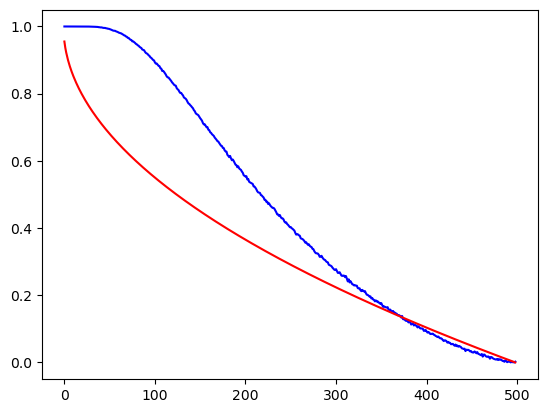

In [12]:
a4 = torch.load("cumulative_precisions4.pth")
# a5 = torch.load("cumulative_precisions5.pth")
x = torch.arange(0, 499, 1)
plt.plot(x, a4, 'b')
plt.plot(x, b[1:500].cpu(), 'r')


In [91]:
d = 3
t0 = torch.eye(d)
m = torch.ones(d,d) / d

t = t0.clone()

for i in range(1,10):
    a = sched.precisions[i]
    torch.softmax(a * t + (1 - a) * m)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])


In [ ]:

# gamma = 0.5772156649 # Euler-Mascheroni Constant
# pi = 3.1415926535 # Pi
# h = (12 * gamma ** 2) / (6 * gamma ** 2 + pi ** 2)
# scales = torch.zeros_like(weights)

# temp = weights.cumsum(dim = 0)
# scales[0] = weights[0] ** 2
# for i in range(1, len(scales)):
#     a = weights[i] ** 2
#     b = weights[i] * h * temp[i - 1]
#     c = scales[i - 1]
#     scales[i] = a + b + c

(-3.0, 3.0)

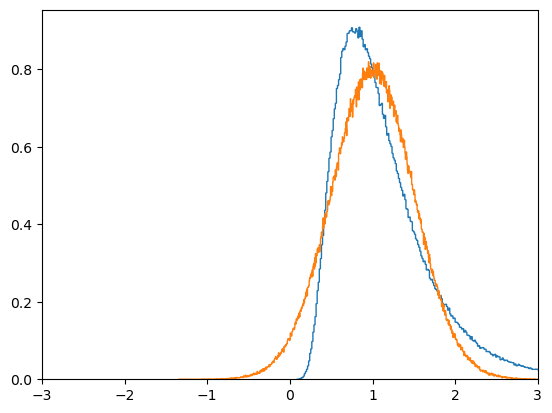

In [23]:
samples = 1000000
res = 1000
v = .5
temp = v * normal_dist.sample((samples,)).squeeze(-1)
lin_comb = torch.exp(temp)
approx = 1 + v * normal_dist.sample((samples,)).squeeze(-1)

y1, x1 = torch.histogram(input = lin_comb, bins = res, density = True)
y2, x2 = torch.histogram(input = approx, bins = res, density = True)

plt.stairs(y1, x1)
plt.stairs(y2, x2)

ax = plt.gca()
ax.set_xlim([-3, 3])

In [31]:
x0 = torch.tensor([[0.0, 1.0, 0.0]]).to(gpu_id)

m = torch.tensor([[1.0, 1.0, 1.0]]).to(gpu_id)
m = m / m.sum()

x = x0.expand(100000, -1)

p = 0.25
v = 1 - p
s = 0.01
noise = gumbel_dist.sample(x.shape).squeeze(-1).to(gpu_id)
x = torch.softmax(torch.log(p * x + (1 - p) * m) + noise, dim = 1)

temp = torch.argmax(x, dim = 1)
probs = F.one_hot(temp, 3).float().mean(dim = 0)
p_bar = p

v_bar = v
s_bar = s

n = normal_dist.sample(m.shape).squeeze(-1).to(gpu_id)
pred = (p * x0 + (1 - p) * m)

print(t, " & ", probs, " & ", pred)

1  &  tensor([0.2506, 0.4974, 0.2520], device='cuda:4')  &  tensor([[0.2500, 0.5000, 0.2500]], device='cuda:4')  &  tensor(1., device='cuda:4')
